# Classification

In this Notebook we will examine bitcoin data and see if we can predict a buy or sell.

https://www.kaggle.com/mczielinski/bitcoin-historical-data/data

Data under CC BY-SA 4.0 License

https://www.kaggle.com/mczielinski/bitcoin-historical-data

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble, model_selection, preprocessing, tree

In [3]:
%%time
# Resampling data from minute interval to day
bit_df = pd.read_csv('../data/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv')
# Convert unix time to datetime
bit_df['date'] = pd.to_datetime(bit_df.Timestamp, unit='s')
# Reset index
bit_df = bit_df.set_index('date')
# Rename columns so easier to code
bit_df = bit_df.rename(columns={'Open':'open', 'High': 'hi', 'Low': 'lo', 
                       'Close': 'close', 'Volume_(BTC)': 'vol_btc',
                       'Volume_(Currency)': 'vol_cur', 
                       'Weighted_Price': 'wp', 'Timestamp': 'ts'})
# Resample and only use recent samples that aren't missing
bit_df = bit_df.resample('d').agg({'open': 'first', 'hi': 'mean', 
    'lo': 'mean', 'close': 'last', 'vol_btc': 'sum',
    'vol_cur': 'sum', 'wp': 'mean', 'ts': 'min'}).iloc[-1000:]
bit_df['buy'] = (bit_df.close.shift(-1) > bit_df.close).astype(int)
# drop last row as it is not complete
bit_df = bit_df.iloc[:-1]

CPU times: user 2.54 s, sys: 385 ms, total: 2.92 s
Wall time: 3.17 s


In [4]:
bit_df

,open,hi,lo,close,vol_btc,vol_cur,wp,ts,buy
date,,,,,,,,,
2015-04-15,221.05,222.340340,222.188347,224.35,9137.584626,2.029524e+06,222.270771,1.429056e+09,1
2015-04-16,224.35,227.834861,227.709000,229.45,8636.837666,1.970069e+06,227.779413,1.429142e+09,0
2015-04-17,229.45,225.029694,224.902819,223.62,7738.360003,1.741497e+06,224.970863,1.429229e+09,1
2015-04-18,223.55,223.413882,223.376458,224.02,5065.649127,1.131269e+06,223.398170,1.429315e+09,1
2015-04-19,224.02,224.679840,224.653271,224.03,5279.787312,1.185860e+06,224.667792,1.429402e+09,1
2015-04-20,224.03,225.098799,225.023875,225.37,7964.055364,1.793096e+06,225.063422,1.429488e+09,1
2015-04-21,225.35,227.241785,227.091604,235.89,10191.153344,2.325789e+06,227.170562,1.429574e+09,0
2015-04-22,235.89,236.084194,235.966285,233.98,7661.273982,1.807241e+06,236.029556,1.429661e+09,1
2015-04-23,233.96,234.940646,234.842826,235.99,6908.700188,1.622914e+06,234.896309,1.429747e+09,0


In [5]:
bit_df.dtypes

open       float64
hi         float64
lo         float64
close      float64
vol_btc    float64
vol_cur    float64
wp         float64
ts         float64
buy          int64
dtype: object

In [6]:
bit_df.describe()

,open,hi,lo,close,vol_btc,vol_cur,wp,ts,buy
count,999.00000,999.000000,999.000000,999.000000,999.000000,9.990000e+02,999.000000,9.990000e+02,999.000000
mean,1838.11015,1843.242022,1841.206354,1854.054895,10350.019927,3.553735e+07,1842.224578,1.472170e+09,0.567568
std,3169.30283,3168.211786,3163.035864,3201.173766,9947.604406,1.097365e+08,3165.632076,2.492906e+07,0.495662
min,211.16000,216.147903,215.791215,211.160000,1525.187302,7.925465e+05,215.969046,1.429056e+09,0.000000
25%,384.61500,384.318854,384.138542,384.850000,5320.152105,2.297687e+06,384.227045,1.450613e+09,0.000000
50%,629.79000,632.740375,632.605924,630.830000,7367.614526,3.484114e+06,632.673702,1.472170e+09,1.000000
75%,1454.14500,1472.029778,1471.148201,1502.495000,11954.181722,1.985804e+07,1471.613323,1.493726e+09,1.000000
max,19650.02000,19545.537632,19529.171910,19650.010000,165763.024424,1.393385e+09,19537.276941,1.515283e+09,1.000000


## Exercise: Load Data

* Load the mushroom data (hint use ``pd.get_dummies``)

Mushroom data https://archive.ics.uci.edu/ml/datasets/Mushroom

data in ``data/agaricus-lepiota.data.txt``

First column is class: edible=e, poisonous=p

Attribute Information:

1. cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s 
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s 
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y 
4. bruises?: bruises=t,no=f 
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s 
6. gill-attachment: attached=a,descending=d,free=f,notched=n 
7. gill-spacing: close=c,crowded=w,distant=d 
8. gill-size: broad=b,narrow=n 
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y 
10. stalk-shape: enlarging=e,tapering=t 
11. stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=? 
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s 
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s 
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
16. veil-type: partial=p,universal=u 
17. veil-color: brown=n,orange=o,white=w,yellow=y 
18. ring-number: none=n,one=o,two=t 
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z 
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y 
21. population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y 
22. habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d



In [8]:
mush_df = pd.read_csv('../data/agaricus-lepiota.data.txt',
     names='class,cap_shape,cap_surface,cap_color,bruises,'
     'odor,g_attachment,g_spacing,g_size,g_color,s_shape,'
     's_root,s_surface_a,s_surface_b,s_color_a,s_color_b,'
     'v_type,v_color,ring_num,ring_type,spore_color,pop,hab'.split(','))
mush_df = pd.get_dummies(mush_df, columns=mush_df.columns).drop(['class_e'],axis=1)

## Decision Tree

* The process of training classifier is to get X and y and call ``.fit``.
* To predict values of y (y hat), call ``.predict(X)``
* To get the accuracy call ``.score(X, y)``

In [9]:
ignore = {'buy'}
cols = [c for c in bit_df.columns if c not in ignore]
X = bit_df[cols]
y = bit_df.buy


In [10]:
dt_model = tree.DecisionTreeClassifier(random_state=42)
dt_model.fit(X, y)
dt_model.score(X, y)

1.0

In [11]:
dt_model.predict(X)

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,

In [12]:
# note that this goes to a Unix path
tree.export_graphviz(dt_model, out_file='/tmp/tree1.dot', 
                     feature_names=X.columns, class_names=['Sell', 'Buy'],
                    filled=True
                    )

In [14]:
%%bash
# This doesn't run on Windows. Also requires that you have graphviz installed (not a Python module)
dot -Tpng -o../img/tree1.png /tmp/tree1.dot

![Big Tree](../img/tree1.png)

In [15]:
dt_model.score(X, y) 

1.0

In [16]:
dt_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [17]:
print(sorted(zip(X.columns, dt_model.feature_importances_), key=lambda x:x[1], reverse=True))

[('ts', 0.19561472423844803), ('vol_cur', 0.1729881682387419), ('vol_btc', 0.15917759447181265), ('open', 0.14654944649457904), ('close', 0.14538155412327577), ('hi', 0.07832314085472028), ('lo', 0.06137666155077928), ('wp', 0.04058871002764301)]


## Exercise: Predict Mushroom Poisonous

* Create a decision tree to model whether a mushroom is poisonous. What is the score?
* What are the most important features?

In [18]:
mush_X = mush_df.iloc[:,1:]
mush_y = mush_df.class_p
mush_dt = tree.DecisionTreeClassifier()
mush_dt.fit(mush_X, mush_y)
mush_dt.score(mush_X, mush_y)

1.0

In [19]:
print(sorted(zip(mush_X.columns, mush_dt.feature_importances_), 
             key=lambda x:x[1], reverse=True))

[('odor_n', 0.6170992067399235), ('s_root_c', 0.1772864247010207), ('s_surface_b_y', 0.09950003919297314), ('spore_color_r', 0.03381277844274255), ('odor_l', 0.023365960761511075), ('odor_a', 0.022784235597324197), ('bruises_t', 0.016582247910514242), ('s_root_b', 0.005634345148165801), ('cap_surface_g', 0.0019650634610951113), ('pop_c', 0.0014562615152182384), ('cap_shape_c', 0.0004919893790665749), ('g_size_b', 2.1447150445001055e-05), ('cap_shape_b', 0.0), ('cap_shape_f', 0.0), ('cap_shape_k', 0.0), ('cap_shape_s', 0.0), ('cap_shape_x', 0.0), ('cap_surface_f', 0.0), ('cap_surface_s', 0.0), ('cap_surface_y', 0.0), ('cap_color_b', 0.0), ('cap_color_c', 0.0), ('cap_color_e', 0.0), ('cap_color_g', 0.0), ('cap_color_n', 0.0), ('cap_color_p', 0.0), ('cap_color_r', 0.0), ('cap_color_u', 0.0), ('cap_color_w', 0.0), ('cap_color_y', 0.0), ('bruises_f', 0.0), ('odor_c', 0.0), ('odor_f', 0.0), ('odor_m', 0.0), ('odor_p', 0.0), ('odor_s', 0.0), ('odor_y', 0.0), ('g_attachment_a', 0.0), ('g_attac

## Try and Generalize the Model

In [20]:
ignore = {'buy'}
cols = [c for c in bit_df.columns if c not in ignore]
X = bit_df[cols]
y = bit_df.buy
X_train, X_test, y_train, y_test = model_selection.\
    train_test_split(X, y, test_size=.3, random_state=42)

In [21]:
dt2 = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
dt2.fit(X_train, y_train)
dt2.score(X_test, y_test)

0.5166666666666667

In [22]:
tree.export_graphviz(dt2, out_file='/tmp/tree2.dot', 
                     feature_names=X.columns, class_names=['Sell', 'Buy'],
                    filled=True
                    )

In [23]:
%%bash
dot -Tpng -o../img/tree2.png /tmp/tree2.dot

![Big Tree](../img/tree2.png)

## Exercise: Decision Tree

* Create a testing and training set 
* Check if the model generalizes to the testing set
* Visualize the tree (if you have graphviz)

In [24]:
mush_X = mush_df.iloc[:,1:]
mush_y = mush_df.class_p
mush_X_train, mush_X_test, mush_y_train, mush_y_test = model_selection.\
    train_test_split(mush_X, mush_y, test_size=.3, random_state=42)
mush_dt = tree.DecisionTreeClassifier()
mush_dt.fit(mush_X_train, mush_y_train)
mush_dt.score(mush_X_test, mush_y_test)

1.0

In [25]:
tree.export_graphviz(mush_dt, out_file='/tmp/tree-mush.dot', 
                     feature_names=mush_X.columns, 
                     class_names=['Edible', 'Poison'],
                    filled=True
                    )

In [26]:
%%bash
dot -Tpng -o../img/tree-mush.png /tmp/tree-mush.dot

![Big Tree](../img/tree-mush.png)

### Feature Engineering
We need to be a little more intelligent about what we are basing our decisions on

In [27]:
def rsi(df, num_periods=14):
    """Relative strength index"""
    prev = df.close.shift(1)
    change = (df.close - prev) / prev
    change = change.rolling(window=num_periods).mean().fillna(0)
    up, down = change.copy(), change.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    up2 = up.rolling(center=False, window=num_periods).mean()
    down2 = down.rolling(center=False, window=num_periods).mean()
    rs = (up2 / down2).fillna(0)
    res = (100 - 100/(1 + rs))
    return res.replace([np.inf], 0)

def stoc(df, num_periods=14):
    """Stochastic Oscillator"""
    cur = df.close
    low = df.close.rolling(center=False, window=num_periods).min() 
    high = df.close.rolling(center=False, window=num_periods).max() 
    return (100 * (cur - low)/(high - low)).fillna(0)

def williams(df, num_periods=14):
    """
    Williams %R ranges from -100 to 0. When its value is above -20, it indicates a sell signal
and when its value is below -80, it indicates a buy signal.
    """
    cur = df.close#.iloc[-1]
    low = df.close.rolling(center=False, window=num_periods).min() #shift(-num_periods) .iloc[-num_periods:].min()
    high = df.close.rolling(center=False, window=num_periods).max() #df.close.iloc[-num_periods:].max()
    return (-100 * (high - cur) / (high - low)).fillna(-50)

def proc(df, num_periods=14):
    """It measures the most recent change in price with respect to the price in n days ago.
    https://www.investopedia.com/terms/p/pricerateofchange.asp
    """
    cur = df.close
    prev = df.close.shift(-num_periods)
    return ((cur - prev)/(prev*100)).fillna(0)

def obv(df, vol='vol_btc'):
    """
    On balance volume - Use volume flow to predict changes

    if close up add vol, if down subtract
    """
    # -1 if down 1 if up
    close_up_or_down = (bit_df.close.diff().le(0) * 2 - 1) 
    obv = (close_up_or_down * bit_df[vol]).cumsum()
    return obv.fillna(0)
    

In [30]:
for func in [rsi, 
             stoc, williams, proc, obv]:
    bit_df[func.__name__] = func(bit_df)

In [31]:
ignore = {'buy'}
cols2 = [c for c in bit_df.columns if c not in ignore]
X = bit_df[cols2]
y = bit_df.buy
X_train, X_test, y_train, y_test = model_selection.\
    train_test_split(X, y, test_size=.3, random_state=42)

In [32]:
dt3 = tree.DecisionTreeClassifier(random_state=42, max_depth=7)
dt3.fit(X_train, y_train)
dt3.score(X_test, y_test)

0.5133333333333333

In [33]:
print(sorted(zip(X.columns, dt3.feature_importances_), key=lambda x:x[1], reverse=True))

[('proc', 0.2470201434824293), ('rsi', 0.16540838871893696), ('vol_cur', 0.14283940994088098), ('ts', 0.1223515314436439), ('obv', 0.11595987880456594), ('vol_btc', 0.07420281796620729), ('stoc', 0.043392805235807234), ('open', 0.02393691990790345), ('lo', 0.022831530841649416), ('close', 0.019581708825130585), ('hi', 0.012547317176618954), ('williams', 0.009927547656225994), ('wp', 0.0)]


In [34]:
rf1 = ensemble.RandomForestClassifier(random_state=3)#, max_depth=7)
rf1.fit(X_train, y_train)
rf1.score(X_test, y_test)

0.4666666666666667

In [35]:
rf1.score(X_train, y_train)


0.9785407725321889

## Exercise: Feature Engineering

The (wheat) seed dataset has a feature engineered column, compactness
\begin{align}
C=4*pi*area/perimeter^2
\end{align}

* Does the classification score improve if this column is included?

The file is at ``data/seeds_dataset.txt``


It has the following fields:

1. area A, 
2. perimeter P, 
3. compactness C = 4*pi*A/P^2, 
4. length of kernel, 
5. width of kernel, 
6. asymmetry coefficient 
7. length of kernel groove. 
8. variety (Kama, Rosa, Canadian)

https://archive.ics.uci.edu/ml/datasets/seeds




In [36]:
seeds = pd.read_table('../data/seeds_dataset.txt', sep=r'\s+',
     names='area,per,comp,len,wid,asym,groove,variety'.split(","))

In [37]:
seed_X = seeds.iloc[:, :-1]
seed_y = seeds.variety
seed_X_train, seed_X_test, seed_y_train, seed_y_test = model_selection.\
    train_test_split(seed_X, seed_y, test_size=.3, random_state=42)
s1 = ensemble.RandomForestClassifier(random_state=42)
s1.fit(seed_X_train, seed_y_train)
s1.score(seed_X_test, seed_y_test)

0.873015873015873

In [38]:
print(sorted(zip(seed_X.columns, s1.feature_importances_), 
             key=lambda x:x[1], reverse=True))

[('groove', 0.24978281788451095), ('area', 0.18721202571841905), ('wid', 0.1739120238564577), ('per', 0.12340862156220689), ('len', 0.11090141876801873), ('asym', 0.10171610343509674), ('comp', 0.05306698877528987)]


In [39]:
seed_X2 = seeds.iloc[:, :-1].drop(['comp'], axis=1)
seed_y2 = seeds.variety
seed_X_train2, seed_X_test2, seed_y_train2, seed_y_test2 = model_selection.\
    train_test_split(seed_X2, seed_y2, test_size=.3, random_state=42)
s2 = ensemble.RandomForestClassifier(random_state=42)
s2.fit(seed_X_train2, seed_y_train2)
s2.score(seed_X_test2, seed_y_test2)

0.8888888888888888

In [40]:
print(sorted(zip(seed_X.columns, s2.feature_importances_), 
             key=lambda x:x[1], reverse=True))

[('asym', 0.27243649036039197), ('len', 0.21322764802663738), ('area', 0.20081148550452688), ('comp', 0.10894067399480542), ('wid', 0.1072700937766202), ('per', 0.09731360833701816)]


## ROC Curve

In [43]:

from sklearn.metrics import auc, confusion_matrix, roc_curve

def fig_with_title(ax, title, figkwargs):
    if figkwargs is None:
        figkwargs = {}
    if not ax:
        fig = plt.figure(**figkwargs)
        ax = plt.subplot(111)
    else:
        fig = plt.gcf()
    if title:
        ax.set_title(title)
    return fig, ax


def plot_roc_curve_binary(clf, X, y, label='ROC Curve (area={area:.3})',
                          title="ROC Curve", pos_label=None, sample_weight=None,
                          ax=None, figkwargs=None):
    ax = ax or plt.subplot(111)
    ax.set_xlim([-.1, 1])
    ax.set_ylim([0, 1.1])
    y_score = clf.predict_proba(X)
    if y_score.shape[1] != 2 and not pos_label:
        warnings.warn("Shape is not binary {} and no pos_label".format(y_score.shape))
        return
    try:
        fpr, tpr, thresholds = roc_curve(y, y_score[:,1], pos_label=pos_label,
                                     sample_weight=sample_weight)
    except ValueError as e:
        if 'is not binary' in str(e):
            warnings.warn("Check if y is numeric")
            raise

    roc_auc = auc(fpr, tpr)
    fig, ax = fig_with_title(ax, title, figkwargs)

    ax.plot(fpr, tpr, label=label.format(area=roc_auc))
    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Guessing')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    return fig, ax

(<matplotlib.figure.Figure at 0x107824d68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f452550>)

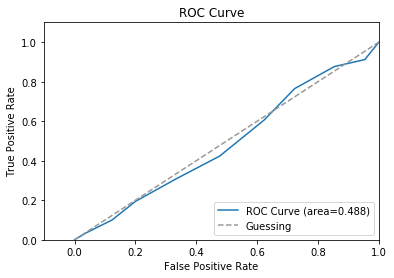

In [44]:
plot_roc_curve_binary(rf1, X_test, y_test, figkwargs={'figsize':(14,10)})

## Exercise - ROC Curve

Print the ROC curve for the seed classifier.

In [45]:
def plot_roc_curve_multilabels(clf, X, y, labels, label_nums, label='ROC Curve {label} (area={area:.3})',
                          title="ROC Curve", sample_weight=None,
                               ax=None, figkwargs=None, add_avg=True):
    y_bin = preprocessing.label_binarize(y, label_nums)
    y_score = clf.predict_proba(X)
    fprs = {}
    tprs = {}
    roc_aucs = {}
    for i, l in enumerate(labels):
        try:
            fprs[i], tprs[i], _ = roc_curve(y_bin[:,i], y_score[:,i],
                                          sample_weight=sample_weight)
            roc_aucs[i] = auc(fprs[i], tprs[i])
        except ValueError as e:
            if 'is not binary' in str(e):
                warnings.warn("Check if y is numeric")
                raise
    fig, ax = fig_with_title(ax, title, figkwargs)
    for i, l in enumerate(labels):
        x = fprs[i]
        y = tprs[i]
        text=label.format(area=roc_aucs[i], label=l)
        ax.plot(x, y, label=text)
    if add_avg:
        f, t, _ = roc_curve(y_bin.ravel(), y_score.ravel())
        r = auc(f, t)
        text=label.format(area=r, label='Average')
        ax.plot(f, t, label=text, color='k', linewidth=2)
    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Guessing')
    ax.set_xlim([-.1, 1])
    ax.set_ylim([0, 1.1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    return fig, ax

(<matplotlib.figure.Figure at 0x10f528fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f50f160>)

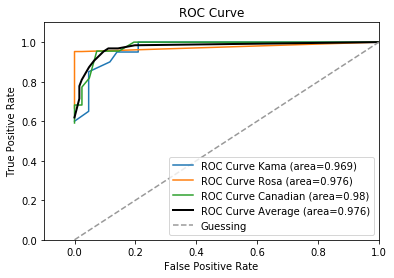

In [46]:
plot_roc_curve_multilabels(s2, seed_X_test2, seed_y_test2, 
                          ['Kama', 'Rosa', 'Canadian'], [1,2,3])

(<matplotlib.figure.Figure at 0x10850dac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f61fcc0>)

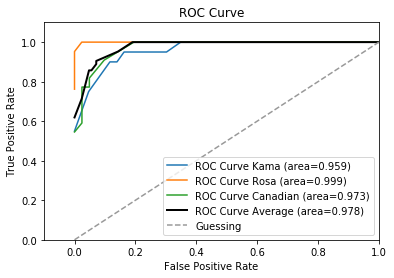

In [47]:
# Note that including compactness lowers the accuracy, but
# ROC average is up slightly
plot_roc_curve_multilabels(s1, seed_X_test, seed_y_test, 
                          ['Kama', 'Rosa', 'Canadian'], [1,2,3])

## Confusion Matrix
A Confusion Matrix is another way to evaluate performance. You can see where false positives (lower left) and false negatives (upper right) are.

In [48]:

def plot_confusion_matrix(clf, X, y, labels, random_state=42, annotate=True,
                          cmap=plt.cm.Blues,
                          title="Confusion Matrix", ax=None, figkwargs=None):
    fig, ax = fig_with_title(ax, title, figkwargs)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(im)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    if annotate:
        for x in range(len(labels)):
            for y in range(len(labels)):
                plt.annotate(str(cm[x][y]),
                             xy=(y,x),
                             ha='center',va='center',color='red', fontsize=25, fontstyle='oblique')

    return fig, ax

(<matplotlib.figure.Figure at 0x10f719320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f719a20>)

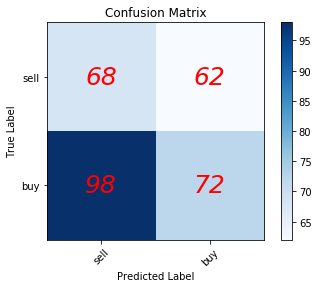

In [49]:
plot_confusion_matrix(rf1, X_test, y_test, ['sell', 'buy'])

(<matplotlib.figure.Figure at 0x10fa003c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f631e80>)

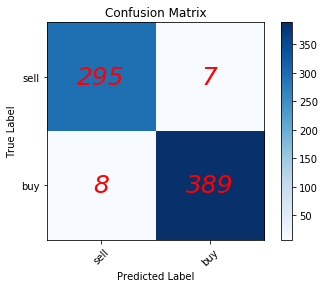

In [51]:
# Notice that the training set performs much better!
plot_confusion_matrix(rf1, X_train, y_train, ['sell', 'buy'])

## Exercise: Confustion Matrix

* Plot a confusion matrix for the seed model

(<matplotlib.figure.Figure at 0x10fae8198>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10fa7eb00>)

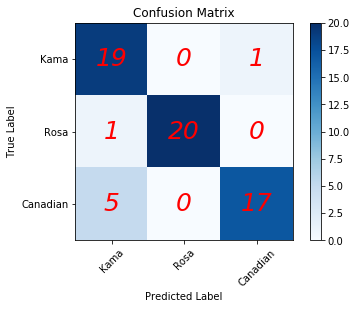

In [52]:
plot_confusion_matrix(s2, seed_X_test2, seed_y_test2, 
                      ['Kama', 'Rosa', 'Canadian'])

(<matplotlib.figure.Figure at 0x10fba3128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10fb9c1d0>)

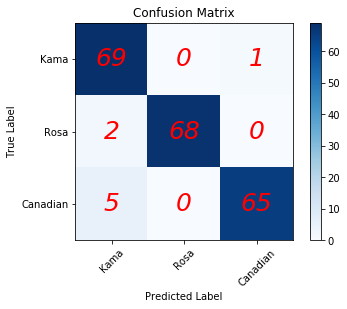

In [53]:
# Notice that using all the data can be misleading, as 
# the model may perform very well on the data it has
# already seen (overfit)
plot_confusion_matrix(s2, seed_X2, seed_y2, 
                      ['Kama', 'Rosa', 'Canadian'])

(<matplotlib.figure.Figure at 0x10fc9ba20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10faef080>)

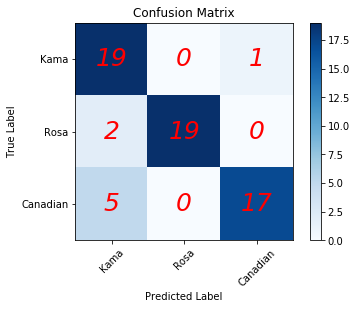

In [54]:
plot_confusion_matrix(s1, seed_X_test, seed_y_test, 
                      ['Kama', 'Rosa', 'Canadian'])

(<matplotlib.figure.Figure at 0x1101019e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1100d76a0>)

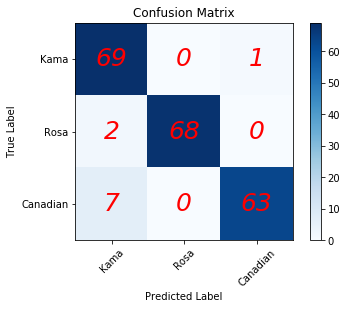

In [55]:
plot_confusion_matrix(s1, seed_X, seed_y, 
                      ['Kama', 'Rosa', 'Canadian'])

### Calibration Curve
from http://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

and 
https://jmetzen.github.io/2015-04-14/calibration.html

Logistic:
	Brier: 0.246
	Precision: 0.564
	Recall: 0.988
	F1: 0.718
	Score: 0.560

Random Forest:
	Brier: 0.313
	Precision: 0.537
	Recall: 0.424
	F1: 0.474
	Score: 0.467

Random Forest + Isotonic:
	Brier: 0.253
	Precision: 0.574
	Recall: 0.729
	F1: 0.642
	Score: 0.540

Random Forest + Sigmoid:
	Brier: 0.248
	Precision: 0.583
	Recall: 0.765
	F1: 0.662
	Score: 0.557



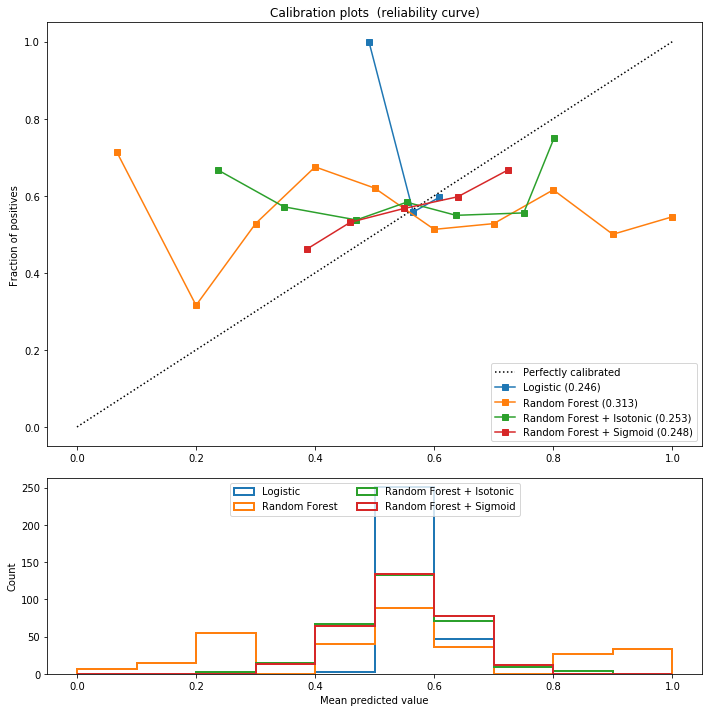

In [56]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)



def plot_calibration_curve(est, name, fig_index,                      
    X_train, X_test, y_train, y_test):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f" % f1_score(y_test, y_pred))
        print("\tScore: %1.3f\n" % clf.score(X_test, y_test))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    
    
plot_calibration_curve(rf1, 'Random Forest', 1,
    X_train, X_test, y_train, y_test)

## Optimizing Models

Models have *hyperparameters* that we can tune. Grid search cross validation will hold out some of the data for testing purposes, so we can pass in the full X and y into it.

In [57]:
%%time
rf4 = ensemble.RandomForestClassifier()
params = {'max_features': [.4, 'auto'],
         'n_estimators': [15, 200, 500],
         'min_samples_leaf': [1, .1],
         'random_state':[42]}
cv = model_selection.GridSearchCV(rf4, params).fit(X, y)
print(cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 0.1, 'n_estimators': 200, 'random_state': 42}
CPU times: user 21.3 s, sys: 180 ms, total: 21.5 s
Wall time: 22.4 s


In [58]:
rf5 = ensemble.RandomForestClassifier(**cv.best_params_)
rf5.fit(X_train, y_train)
rf5.score(X_test, y_test)

0.5633333333333334

In [62]:
rf6 = ensemble.RandomForestClassifier(random_state=41)
rf6.fit(X_train, y_train)
rf6.score(X_test, y_test)

0.5066666666666667

## Exercise: Optimize Model

In [63]:
# base
s1.score(seed_X_test, seed_y_test)

0.873015873015873

In [65]:
%%time
s3 = ensemble.RandomForestClassifier()
params = {'max_features': [.4, 'auto'],
         'n_estimators': [15, 200, 500],
         'min_samples_leaf': [1, .1],
         'random_state':[42]}
seed_cv = model_selection.GridSearchCV(s3, params).fit(seed_X, seed_y)
print(seed_cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_state': 42}
CPU times: user 12.7 s, sys: 80.5 ms, total: 12.8 s
Wall time: 13 s


In [66]:
s4 = ensemble.RandomForestClassifier(**seed_cv.best_params_)
s4.fit(seed_X_train, seed_y_train)
s4.score(seed_X_test, seed_y_test)

0.8888888888888888

## Learning Curves: Do we have enough data?

http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

<module 'matplotlib.pyplot' from '/Users/matt/work/courses/machine-learning-with-python-classification/.env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

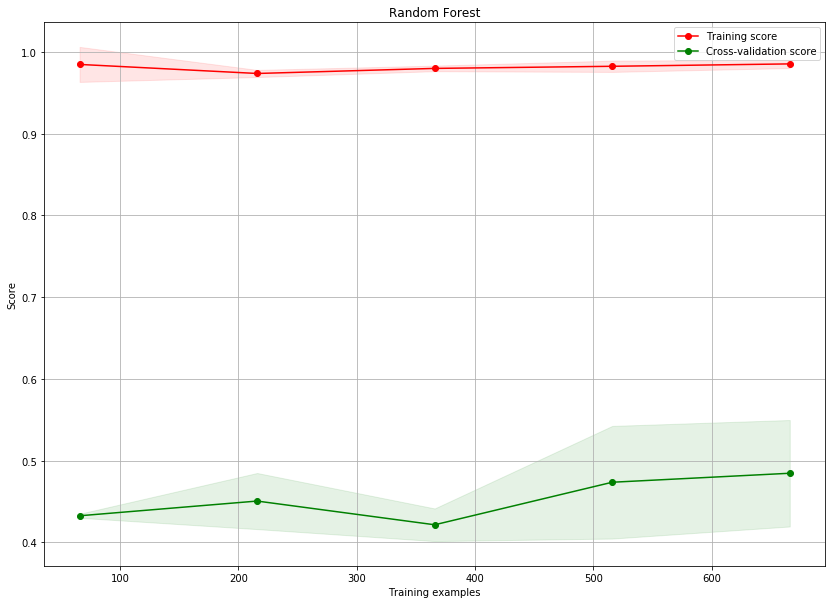

In [67]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                       fig_opts=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    fig_opts = fig_opts or {}
    plt.figure(**fig_opts)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(rf6, 'Random Forest', X, y, fig_opts={'figsize':(14,10)})

In [69]:
%%time
def get_data(filename, resample='d', size=1000):
    bit_df = pd.read_csv(filename)
    # Convert unix time to datetime
    bit_df['date'] = pd.to_datetime(bit_df.Timestamp, unit='s')
    # Reset index
    bit_df = bit_df.set_index('date')
    # Rename columns so easier to code
    bit_df = bit_df.rename(columns={'Open':'open', 'High': 'hi', 'Low': 'lo', 
                           'Close': 'close', 'Volume_(BTC)': 'vol_btc',
                           'Volume_(Currency)': 'vol_cur', 
                           'Weighted_Price': 'wp', 'Timestamp': 'ts'})
    # Resample and only use recent samples that aren't missing
    bit_df = bit_df.resample(resample).agg({'open': 'first', 'hi': 'mean', 
        'lo': 'mean', 'close': 'last', 'vol_btc': 'sum',
        'vol_cur': 'sum', 'wp': 'mean', 'ts': 'min'})
    
    # drop if open is missing - ADDED!
    bit_df = bit_df[~bit_df.open.isnull()]

    if size:
        bit_df = bit_df.iloc[-size:]
    bit_df['buy'] = (bit_df.close.shift(-1) > bit_df.close).astype(int)
    # drop last row as it is not complete
    bit_df = bit_df.iloc[:-1]
    return bit_df

hour_df = get_data('../data/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv', 
                   resample='h', size=None)
print(hour_df.shape)
    

(26246, 9)
CPU times: user 2.6 s, sys: 466 ms, total: 3.06 s
Wall time: 3.29 s


In [70]:
def get_test_train(df):
    for func in [rsi, 
             stoc, williams, proc, obv]:
        df[func.__name__] = func(df)
    
    ignore = {'buy'}
    cols2 = [c for c in df.columns if c not in ignore]
    X = df[cols2]
    X = X.fillna(0)
    y = df.buy
    X_train, X_test, y_train, y_test = model_selection.\
        train_test_split(X, y, test_size=.3, random_state=42)
    return X_train, X_test, y_train, y_test

hX_train, hX_test, hy_train, hy_test = get_test_train(hour_df)

In [71]:
hX_train.isnull().any()

open        False
hi          False
lo          False
close       False
vol_btc     False
vol_cur     False
wp          False
ts          False
rsi         False
stoc        False
williams    False
proc        False
obv         False
dtype: bool

<module 'matplotlib.pyplot' from '/Users/matt/work/courses/machine-learning-with-python-classification/.env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

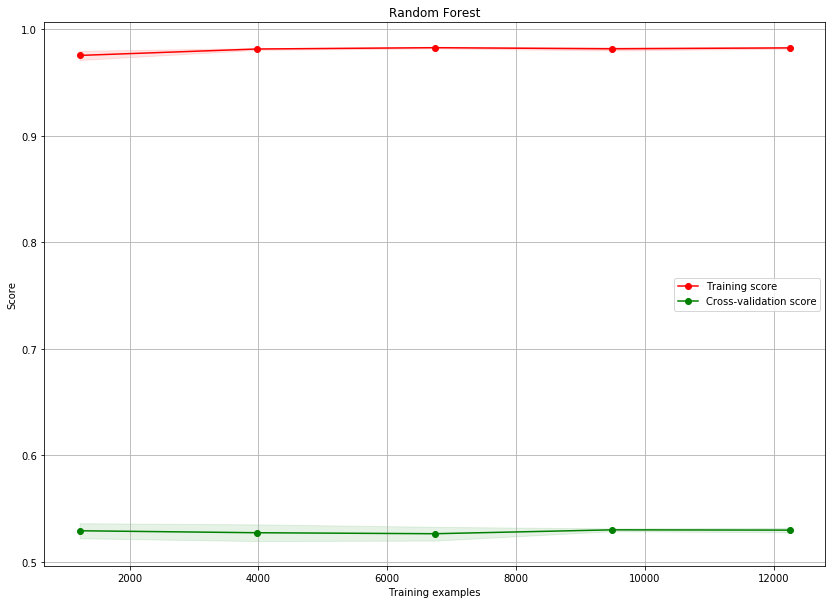

In [72]:
plot_learning_curve(ensemble.RandomForestClassifier(), 
                    'Random Forest', hX_train, hy_train, fig_opts={'figsize':(14,10)})

## Exercise: Learning Curves
* Run a learning curve against the seed data? How much data do we need to train on?

<module 'matplotlib.pyplot' from '/Users/matt/work/courses/machine-learning-with-python-classification/.env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

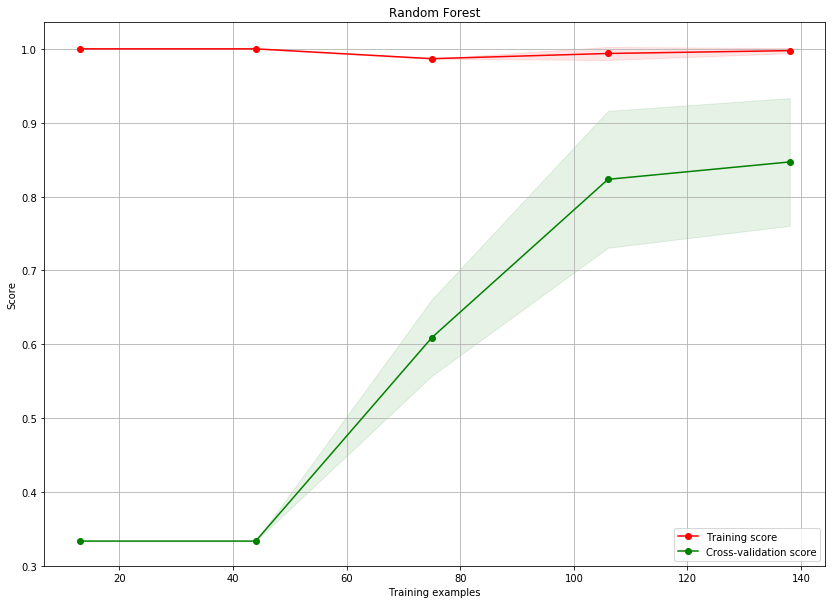

In [73]:
plot_learning_curve(ensemble.RandomForestClassifier(), 
                    'Random Forest', seed_X, seed_y, fig_opts={'figsize':(14,10)})